In the lab below I build upon the existing MNIST notebook and try my own loss functions, optimizers, and CNN architectures to see what works best for the MNIST dataset

# Setup Imports

In [4]:
%matplotlib inline 
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from keras.datasets import mnist
from sklearn.preprocessing import scale
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from tensorflow.keras import layers,losses,models
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.applications.imagenet_utils import preprocess_input as zero_mean
from keras.callbacks import EarlyStopping
from sklearn.model_selection import validation_curve

# Loading MNIST Data using Keras

In [5]:
#import training and testing data
(data_train, label_train), (data_test, label_test) = mnist.load_data()

#this turns data from 28x28 image into 1D array of 784
data_train_reshaped = data_train.reshape(data_train.shape[0], -1)
data_test_reshaped = data_test.reshape(data_test.shape[0], -1)

In [6]:
#normalize data
data_train_reshaped=data_train_reshaped/255
data_test_reshaped=data_test_reshaped/255


#scales data
data_train_reshaped=scale(data_train_reshaped)
data_test_reshaped=scale(data_test_reshaped)

In [7]:
#concatenate training and testing data and labels (and s=divide by 255 again?)
data_complete=np.concatenate((data_train_reshaped,data_test_reshaped))
data_complete=data_complete/255.0
data_complete=scale(data_complete)
label_complete=np.concatenate((label_train,label_test))
data_complete=data_complete.tolist()
label_complete=label_complete.tolist()


#### Visualising Data 



In [8]:
dictdata={'Image': [],'Label':[]}
for i in range(6):
  dictdata['Image'].append(data_train[i][:])
  dictdata['Label'].append(label_train[i])

In [9]:
displaydf=pd.DataFrame(dictdata)

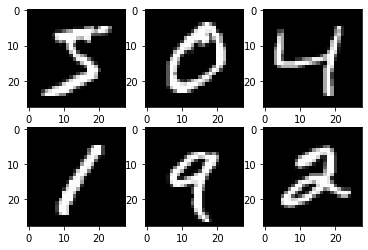

In [10]:
f, axarr = plt.subplots(2,3)
for i in range(6):
  axarr[int(i/3),i%3].imshow(displaydf['Image'][i],cmap='gray')

In [11]:
#Test Samples
dictdatatest={'Image': [],'Label':[]}
for i in range(6):
  dictdatatest['Image'].append(data_test[i][:])
  dictdatatest['Label'].append(label_test[i])

displaydftest=pd.DataFrame(dictdatatest)

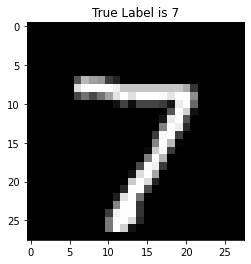

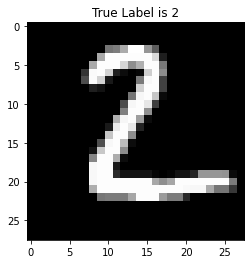

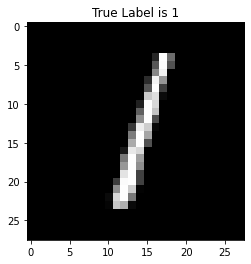

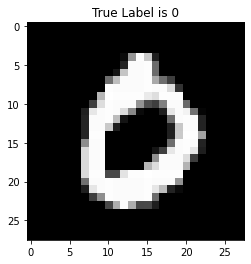

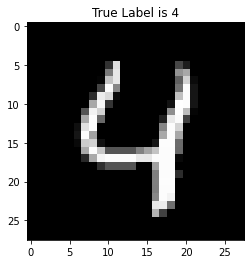

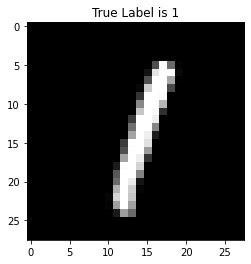

In [12]:
for i in range(6):
  plt.figure()
  plt.title('True Label is %i'%displaydftest['Label'][i])
  plt.imshow(displaydftest['Image'][i],cmap='gray')

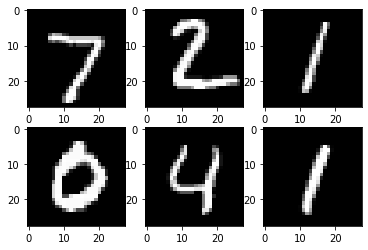

In [13]:
f, axarr = plt.subplots(2,3)
for i in range(6):
  axarr[int(i/3),i%3].imshow(displaydftest['Image'][i],cmap='gray')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


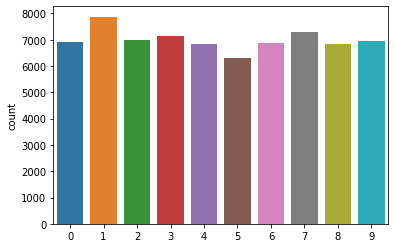

In [14]:
# Complete Dataset Histogram
sns.countplot(label_complete);

PCA

In [15]:
# pca=PCA(n_components=459)
n_components=20
pca=PCA(n_components=20)
data_PCA_train_actual=pca.fit_transform(data_train_reshaped)
data_PCA_test_actual=pca.transform(data_test_reshaped)

0.38058832854178776

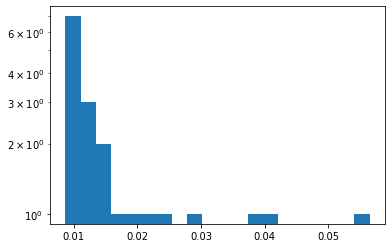

In [16]:
plt.hist(pca.explained_variance_ratio_, bins=n_components, log=True)
pca.explained_variance_ratio_.sum()

MDA

In [17]:
dim_redn_LDA=9
lda=LDA(n_components=dim_redn_LDA)
data_LDA_train_actual=lda.fit_transform(data_train_reshaped,label_train)
data_LDA_test_actual=lda.transform(data_test_reshaped)

1.0

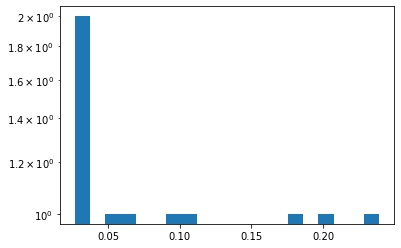

In [18]:
plt.hist(lda.explained_variance_ratio_, bins=n_components, log=True)
lda.explained_variance_ratio_.sum()

# CNNs


## Model Data Setup

In [30]:
paddings=tf.constant([[0,0],[2,2],[2,2]])
data_train_padded=tf.pad(data_train,paddings,"CONSTANT")
data_train_padded.shape
data_test_padded=tf.pad(data_test,paddings,"CONSTANT")
data_test_padded.shape

TensorShape([10000, 32, 32])

In [31]:
data_train_padded=data_train_padded/255
data_test_padded=data_test_padded/255

In [32]:
data_train_padded_array=np.array(data_train_padded)/255.0
data_test_padded_array=np.array(data_test_padded)/255.0

In [33]:
data_train_CNN= data_train_padded_array.reshape(data_train_padded_array.shape[0], -1)
data_test_CNN= data_test_padded_array.reshape(data_test_padded_array.shape[0], -1)
data_train_CNN.shape

(60000, 1024)

In [34]:
data_train_CNN_array=data_train_CNN/255.0
data_test_CNN_array=data_test_CNN/255.0

In [35]:
[x,y,z]=data_train_padded.shape

In [36]:
#Adding Channel information (Grayscale)
data_train_CNN = tf.expand_dims(data_train_padded, axis=3, name=None)
data_test_CNN = tf.expand_dims(data_test_padded, axis=3, name=None)

## Baseline Model

In [37]:
#Defining LeNet5

model = models.Sequential()
model.add(layers.Conv2D(6, 5, activation='tanh', input_shape=data_train_CNN.shape[1:]))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(16, 5, activation='tanh'))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(120, 5, activation='tanh'))
model.add(layers.Flatten())
model.add(layers.Dense(84, activation='tanh'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                                 
 activation_2 (Activation)   (None, 14, 14, 6)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_3 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 activation_3 (Activation)   (None, 5, 5, 16)         

In [38]:
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = model.fit(data_train_CNN, label_train, batch_size=64, epochs=40, validation_data=(data_test_CNN, label_test))

Epoch 1/40
938/938 [==============================] - 7s 7ms/step - loss: 1.8855 - accuracy: 0.2923 - val_loss: 0.4713 - val_accuracy: 0.8495
Epoch 2/40
938/938 [==============================] - 6s 7ms/step - loss: 0.3716 - accuracy: 0.8791 - val_loss: 0.2672 - val_accuracy: 0.9127
Epoch 3/40
938/938 [==============================] - 8s 9ms/step - loss: 0.2593 - accuracy: 0.9180 - val_loss: 0.2283 - val_accuracy: 0.9281
Epoch 4/40
938/938 [==============================] - 9s 9ms/step - loss: 0.2118 - accuracy: 0.9331 - val_loss: 0.1687 - val_accuracy: 0.9478
Epoch 5/40
938/938 [==============================] - 6s 7ms/step - loss: 0.1835 - accuracy: 0.9426 - val_loss: 0.1699 - val_accuracy: 0.9452
Epoch 6/40
938/938 [==============================] - 10s 10ms/step - loss: 0.1608 - accuracy: 0.9482 - val_loss: 0.1202 - val_accuracy: 0.9636
Epoch 7/40
938/938 [==============================] - 10s 11ms/step - loss: 0.1451 - accuracy: 0.9538 - val_loss: 0.1649 - val_accuracy: 0.9465
Ep

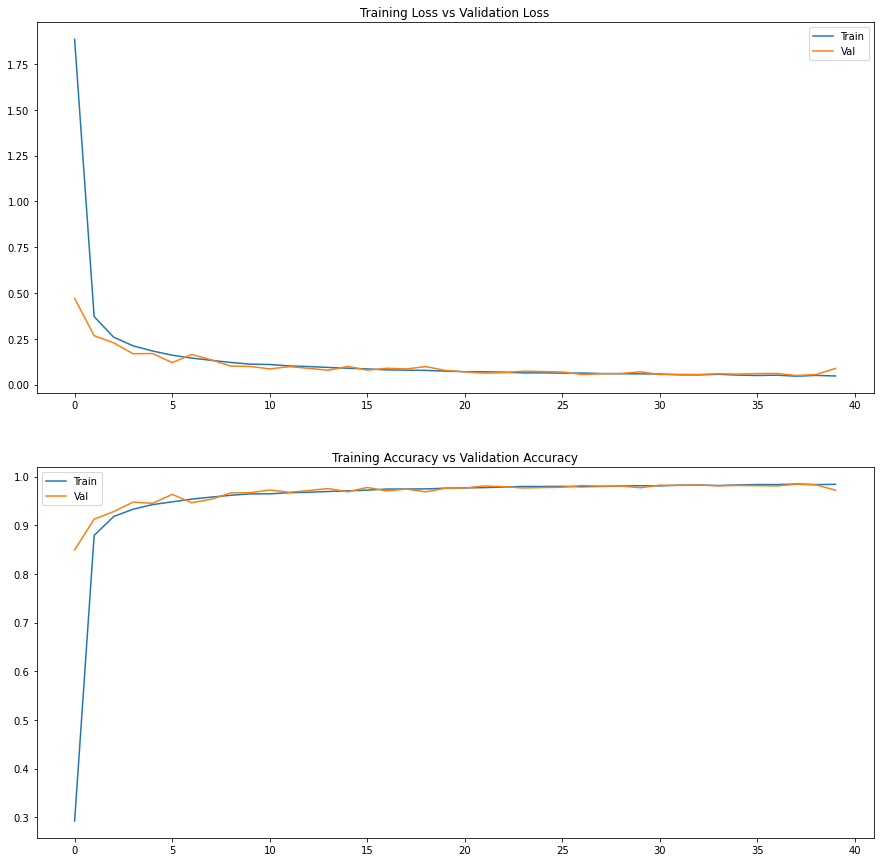

In [39]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

In [40]:
model.evaluate(data_test_CNN, label_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0887 - accuracy: 0.9722


[0.08874844014644623, 0.9721999764442444]

## Evaluating Optimisers

here I changed the optimizer functions to see which would work best

In [41]:
def create_model(model_loss = 'sparse_categorical_crossentropy', model_optimizer = 'adam'):
  model = models.Sequential()
  model.add(layers.Conv2D(6, 5, activation='tanh', input_shape=data_train_CNN.shape[1:]))
  model.add(layers.AveragePooling2D(2))
  model.add(layers.Activation('sigmoid'))
  model.add(layers.Conv2D(16, 5, activation='tanh'))
  model.add(layers.AveragePooling2D(2))
  model.add(layers.Activation('sigmoid'))
  model.add(layers.Conv2D(120, 5, activation='tanh'))
  model.add(layers.Flatten())
  model.add(layers.Dense(84, activation='tanh'))
  model.add(layers.Dense(10, activation='softmax'))

  #compile model
  model.compile(optimizer= model_optimizer, loss = model_loss, metrics=['accuracy'])

  return model

### Adamax

In [26]:
model = create_model(model_loss='sparse_categorical_crossentropy', model_optimizer='Adamax')
history = model.fit(data_train_CNN, label_train, batch_size=64, epochs=10, validation_data=(data_test_CNN, label_test))

Epoch 1/10
938/938 [==============================] - 11s 10ms/step - loss: 1.5809 - accuracy: 0.4634 - val_loss: 0.5880 - val_accuracy: 0.8251
Epoch 2/10
938/938 [==============================] - 9s 10ms/step - loss: 0.4458 - accuracy: 0.8667 - val_loss: 0.3434 - val_accuracy: 0.8959
Epoch 3/10
938/938 [==============================] - 12s 12ms/step - loss: 0.3358 - accuracy: 0.8964 - val_loss: 0.3036 - val_accuracy: 0.9035
Epoch 4/10
938/938 [==============================] - 12s 13ms/step - loss: 0.2891 - accuracy: 0.9098 - val_loss: 0.2574 - val_accuracy: 0.9195
Epoch 5/10
938/938 [==============================] - 10s 11ms/step - loss: 0.2550 - accuracy: 0.9204 - val_loss: 0.2220 - val_accuracy: 0.9312
Epoch 6/10
938/938 [==============================] - 11s 11ms/step - loss: 0.2310 - accuracy: 0.9275 - val_loss: 0.2084 - val_accuracy: 0.9329
Epoch 7/10
938/938 [==============================] - 11s 11ms/step - loss: 0.2061 - accuracy: 0.9359 - val_loss: 0.2102 - val_accuracy: 

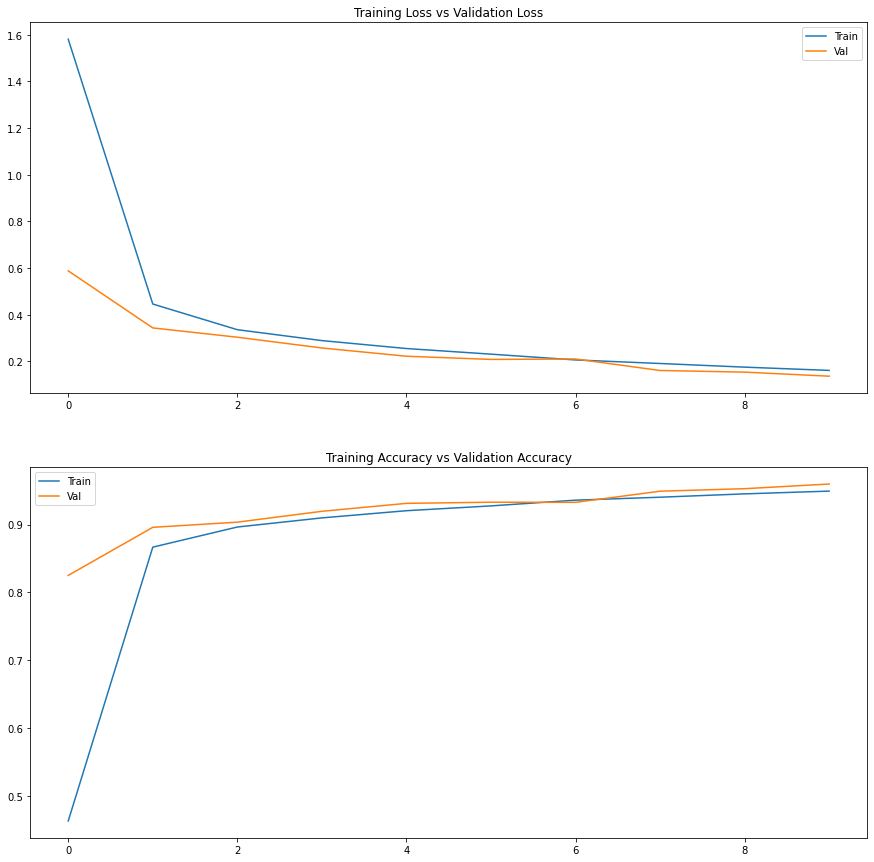

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

### SGD

In [28]:
model = create_model(model_loss='sparse_categorical_crossentropy', model_optimizer='sgd')
history = model.fit(data_train_CNN, label_train, batch_size=64, epochs=10, validation_data=(data_test_CNN, label_test))

Epoch 1/10
938/938 [==============================] - 7s 7ms/step - loss: 2.3063 - accuracy: 0.1063 - val_loss: 2.3063 - val_accuracy: 0.0974
Epoch 2/10
938/938 [==============================] - 7s 7ms/step - loss: 2.2974 - accuracy: 0.1199 - val_loss: 2.2922 - val_accuracy: 0.1135
Epoch 3/10
938/938 [==============================] - 9s 9ms/step - loss: 2.2676 - accuracy: 0.1701 - val_loss: 2.2176 - val_accuracy: 0.1033
Epoch 4/10
938/938 [==============================] - 10s 11ms/step - loss: 1.8953 - accuracy: 0.4642 - val_loss: 1.3612 - val_accuracy: 0.6862
Epoch 5/10
938/938 [==============================] - 9s 10ms/step - loss: 0.9576 - accuracy: 0.7446 - val_loss: 0.7040 - val_accuracy: 0.8060
Epoch 6/10
938/938 [==============================] - 7s 7ms/step - loss: 0.6269 - accuracy: 0.8202 - val_loss: 0.5409 - val_accuracy: 0.8447
Epoch 7/10
938/938 [==============================] - 6s 6ms/step - loss: 0.5107 - accuracy: 0.8518 - val_loss: 0.4999 - val_accuracy: 0.8380
Epo

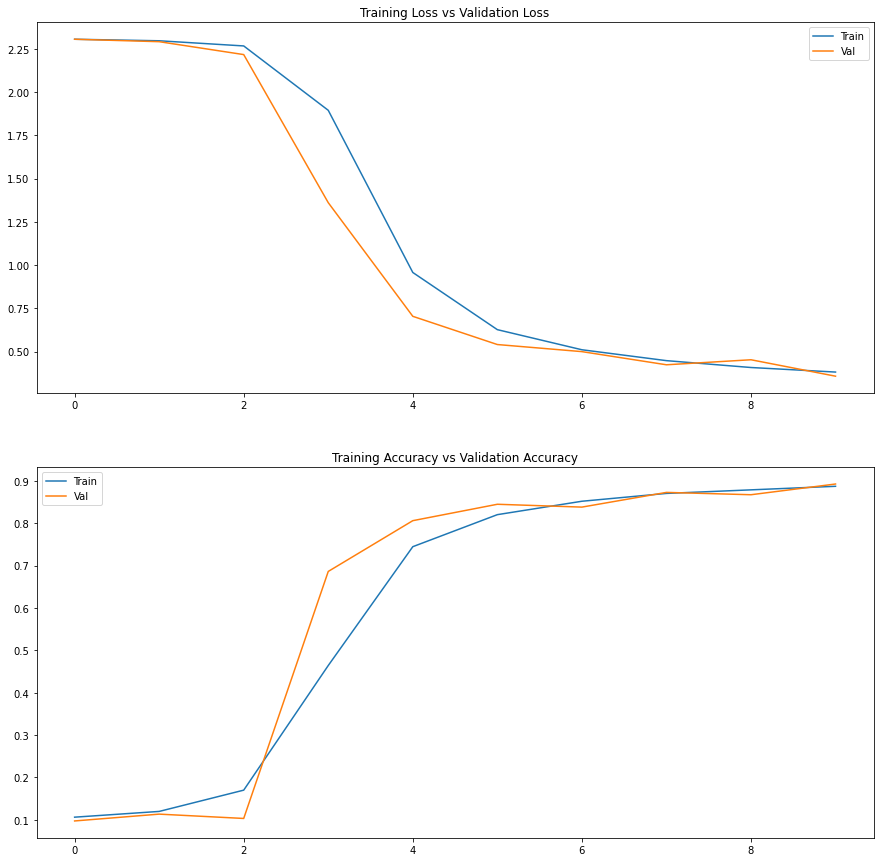

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

### RMSprop

In [30]:
model = create_model(model_loss='sparse_categorical_crossentropy', model_optimizer='RMSprop')
history = model.fit(data_train_CNN, label_train, batch_size=64, epochs=10, validation_data=(data_test_CNN, label_test))

Epoch 1/10
938/938 [==============================] - 8s 8ms/step - loss: 1.3347 - accuracy: 0.5227 - val_loss: 0.6798 - val_accuracy: 0.7453
Epoch 2/10
938/938 [==============================] - 11s 11ms/step - loss: 0.4369 - accuracy: 0.8571 - val_loss: 0.2783 - val_accuracy: 0.9152
Epoch 3/10
938/938 [==============================] - 11s 12ms/step - loss: 0.3130 - accuracy: 0.8985 - val_loss: 0.2725 - val_accuracy: 0.9098
Epoch 4/10
938/938 [==============================] - 11s 11ms/step - loss: 0.2518 - accuracy: 0.9189 - val_loss: 0.2978 - val_accuracy: 0.9024
Epoch 5/10
938/938 [==============================] - 7s 8ms/step - loss: 0.2139 - accuracy: 0.9316 - val_loss: 0.2160 - val_accuracy: 0.9307
Epoch 6/10
938/938 [==============================] - 7s 7ms/step - loss: 0.1880 - accuracy: 0.9396 - val_loss: 0.1519 - val_accuracy: 0.9509
Epoch 7/10
938/938 [==============================] - 7s 8ms/step - loss: 0.1680 - accuracy: 0.9460 - val_loss: 0.1686 - val_accuracy: 0.9463


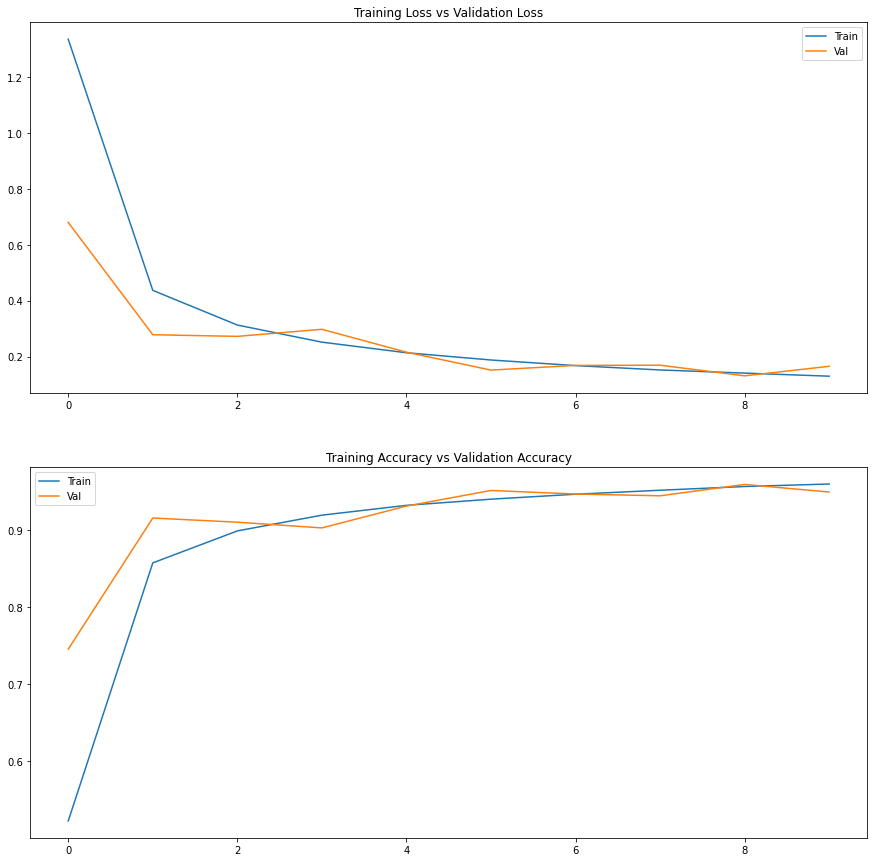

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

While all did quite well, ultimately the Adamax did the best and took the fewest epochs to reach great accuracy. Adamx had a final accuracy in 10 epochs of .9597

## Changing Loss Functions

here I played around with different loss fucntions to see which would work best

### MSE

In [32]:
model = create_model(model_loss='mse', model_optimizer='adam')
history = model.fit(data_train_CNN, label_train, batch_size=64, epochs=10, validation_data=(data_test_CNN, label_test))

Epoch 1/10
938/938 [==============================] - 14s 14ms/step - loss: 27.3046 - accuracy: 0.1337 - val_loss: 27.2503 - val_accuracy: 0.1278
Epoch 2/10
938/938 [==============================] - 9s 9ms/step - loss: 27.3045 - accuracy: 0.1333 - val_loss: 27.2503 - val_accuracy: 0.0978
Epoch 3/10
938/938 [==============================] - 7s 7ms/step - loss: 27.3045 - accuracy: 0.1217 - val_loss: 27.2503 - val_accuracy: 0.0895
Epoch 4/10
938/938 [==============================] - 11s 11ms/step - loss: 27.3045 - accuracy: 0.1143 - val_loss: 27.2503 - val_accuracy: 0.0958
Epoch 5/10
938/938 [==============================] - 9s 10ms/step - loss: 27.3045 - accuracy: 0.1026 - val_loss: 27.2503 - val_accuracy: 0.1028
Epoch 6/10
938/938 [==============================] - 7s 7ms/step - loss: 27.3045 - accuracy: 0.1023 - val_loss: 27.2503 - val_accuracy: 0.1077
Epoch 7/10
938/938 [==============================] - 7s 7ms/step - loss: 27.3045 - accuracy: 0.1016 - val_loss: 27.2503 - val_accu

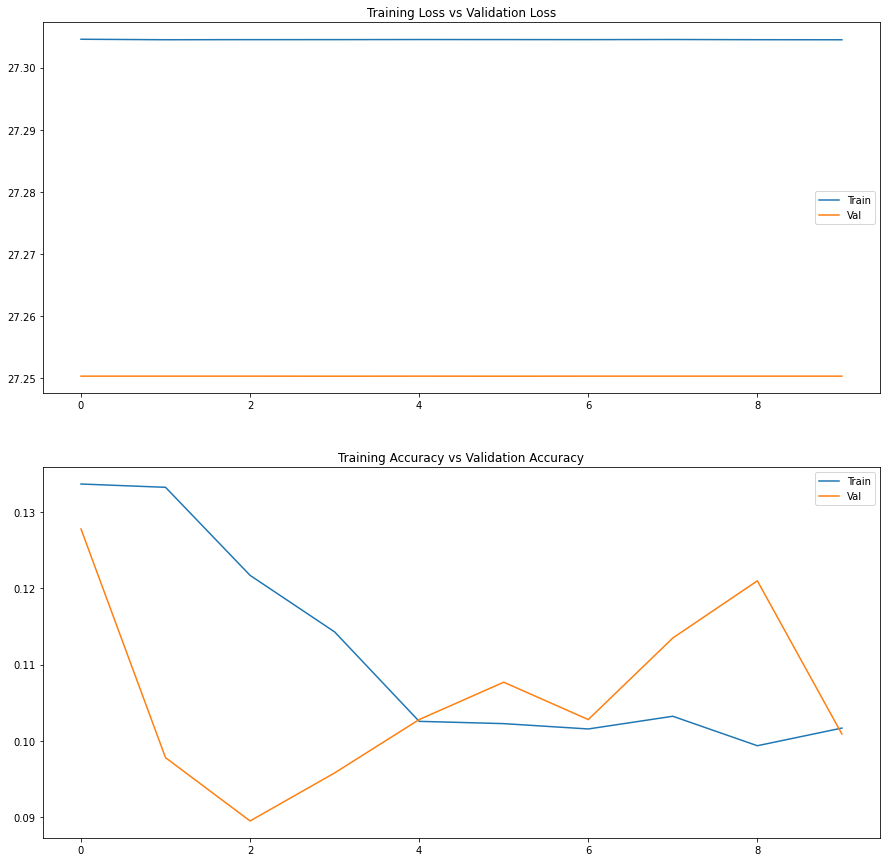

In [33]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

### categorical_hinge

In [43]:
model = create_model(model_loss='categorical_hinge', model_optimizer='adam')
history = model.fit(data_train_CNN, label_train, batch_size=64, epochs=10, validation_data=(data_test_CNN, label_test))

Epoch 1/10
938/938 [==============================] - 11s 11ms/step - loss: 0.1112 - accuracy: 0.1009 - val_loss: 0.1089 - val_accuracy: 0.1010
Epoch 2/10
938/938 [==============================] - 10s 11ms/step - loss: 0.1094 - accuracy: 0.1008 - val_loss: 0.1090 - val_accuracy: 0.1009
Epoch 3/10
938/938 [==============================] - 10s 11ms/step - loss: 0.1093 - accuracy: 0.0991 - val_loss: 0.1084 - val_accuracy: 0.0982
Epoch 4/10
938/938 [==============================] - 9s 10ms/step - loss: 0.1092 - accuracy: 0.0997 - val_loss: 0.1083 - val_accuracy: 0.1135
Epoch 5/10
938/938 [==============================] - 7s 7ms/step - loss: 0.1093 - accuracy: 0.0987 - val_loss: 0.1083 - val_accuracy: 0.0974
Epoch 6/10
938/938 [==============================] - 7s 7ms/step - loss: 0.1092 - accuracy: 0.0985 - val_loss: 0.1083 - val_accuracy: 0.1010
Epoch 7/10
938/938 [==============================] - 7s 7ms/step - loss: 0.1092 - accuracy: 0.1015 - val_loss: 0.1086 - val_accuracy: 0.1135

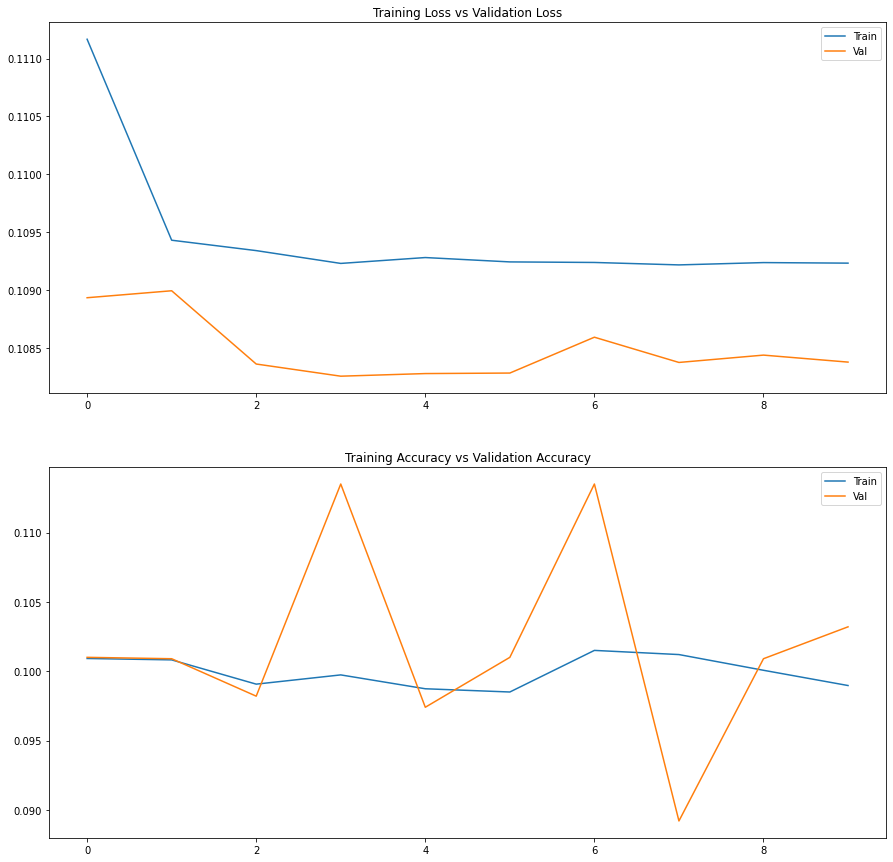

In [44]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

### huber_loss

In [45]:
model = create_model(model_loss='huber_loss', model_optimizer='adam')
history = model.fit(data_train_CNN, label_train, batch_size=64, epochs=10, validation_data=(data_test_CNN, label_test))

Epoch 1/10
938/938 [==============================] - 8s 7ms/step - loss: 3.9142 - accuracy: 0.1259 - val_loss: 3.9033 - val_accuracy: 0.1165
Epoch 2/10
938/938 [==============================] - 6s 7ms/step - loss: 3.9142 - accuracy: 0.1135 - val_loss: 3.9033 - val_accuracy: 0.1023
Epoch 3/10
938/938 [==============================] - 7s 7ms/step - loss: 3.9142 - accuracy: 0.1046 - val_loss: 3.9033 - val_accuracy: 0.1211
Epoch 4/10
938/938 [==============================] - 7s 7ms/step - loss: 3.9142 - accuracy: 0.1013 - val_loss: 3.9033 - val_accuracy: 0.1028
Epoch 5/10
938/938 [==============================] - 7s 7ms/step - loss: 3.9142 - accuracy: 0.0956 - val_loss: 3.9033 - val_accuracy: 0.1097
Epoch 6/10
938/938 [==============================] - 7s 8ms/step - loss: 3.9142 - accuracy: 0.0968 - val_loss: 3.9033 - val_accuracy: 0.1027
Epoch 7/10
938/938 [==============================] - 7s 7ms/step - loss: 3.9142 - accuracy: 0.1015 - val_loss: 3.9033 - val_accuracy: 0.0823
Epoch 

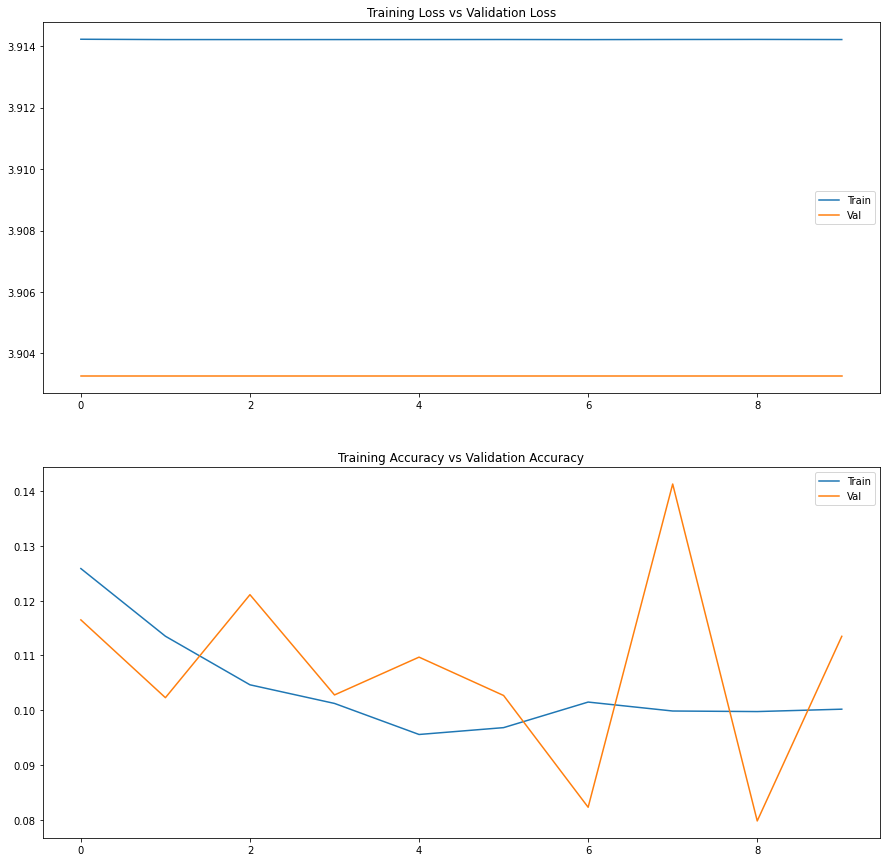

In [46]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

clearly none of the loss functions worked too well with the given task, maybe because they don't work best with classification

## Changing Architecture

here I changed the architectures of the models to see what would happen to the accuracy of the model

### Changing Architecture using MaxPooling instead of AvgPooling

In [54]:
def new_arch_model(model_loss = 'sparse_categorical_crossentropy', model_optimizer = 'adam'):
  model = models.Sequential()
  
  model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
  model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  model.add(layers.MaxPooling2D())

  model.add(layers.Flatten())

  model.add(layers.Dense(units=120, activation='relu'))

  model.add(layers.Dense(units=84, activation='relu'))

  model.add(layers.Dense(units=40, activation='relu'))

  model.add(layers.Dense(units=10, activation = 'softmax'))

  #compile model
  model.compile(optimizer= model_optimizer, loss = model_loss, metrics=['accuracy'])

  return model

In [55]:
model = new_arch_model(model_loss='sparse_categorical_crossentropy', model_optimizer='adam')
history = model.fit(data_train_CNN, label_train, batch_size=64, epochs=10, validation_data=(data_test_CNN, label_test))

Epoch 1/10
938/938 [==============================] - 7s 6ms/step - loss: 0.3028 - accuracy: 0.9052 - val_loss: 0.1019 - val_accuracy: 0.9693
Epoch 2/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0841 - accuracy: 0.9741 - val_loss: 0.0663 - val_accuracy: 0.9785
Epoch 3/10
938/938 [==============================] - 8s 9ms/step - loss: 0.0598 - accuracy: 0.9815 - val_loss: 0.0463 - val_accuracy: 0.9839
Epoch 4/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0475 - accuracy: 0.9851 - val_loss: 0.0567 - val_accuracy: 0.9810
Epoch 5/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0372 - accuracy: 0.9880 - val_loss: 0.0480 - val_accuracy: 0.9853
Epoch 6/10
938/938 [==============================] - 8s 8ms/step - loss: 0.0305 - accuracy: 0.9905 - val_loss: 0.0435 - val_accuracy: 0.9865
Epoch 7/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0266 - accuracy: 0.9916 - val_loss: 0.0460 - val_accuracy: 0.9864
Epo

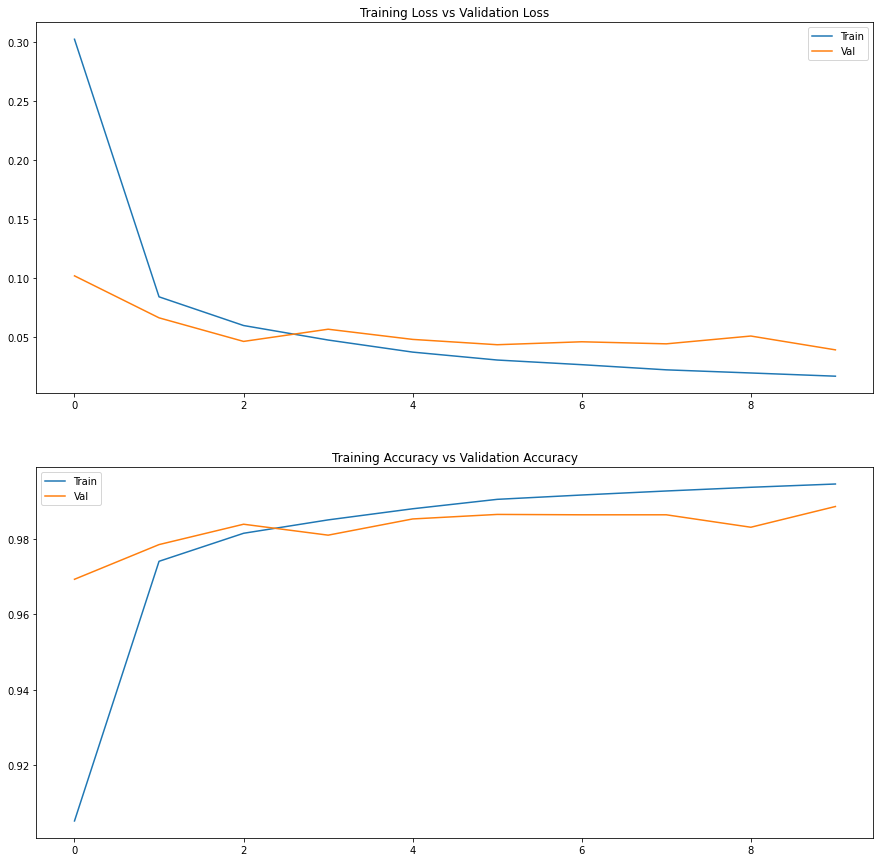

In [56]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

### Changing Architecture (activation functions) from relu to sigmoid

In [57]:
def new_arch_model(model_loss = 'sparse_categorical_crossentropy', model_optimizer = 'adam'):
  model = models.Sequential()
  
  model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='sigmoid', input_shape=(32,32,1)))
  model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='sigmoid'))
  model.add(layers.MaxPooling2D())

  model.add(layers.Flatten())

  model.add(layers.Dense(units=120, activation='sigmoid'))

  model.add(layers.Dense(units=84, activation='sigmoid'))

  model.add(layers.Dense(units=40, activation='sigmoid'))

  model.add(layers.Dense(units=10, activation = 'softmax'))

  #compile model
  model.compile(optimizer= model_optimizer, loss = model_loss, metrics=['accuracy'])

  return model

In [58]:
model = new_arch_model(model_loss='sparse_categorical_crossentropy', model_optimizer='adam')
history = model.fit(data_train_CNN, label_train, batch_size=64, epochs=10, validation_data=(data_test_CNN, label_test))

Epoch 1/10
938/938 [==============================] - 9s 9ms/step - loss: 1.4666 - accuracy: 0.4981 - val_loss: 0.3979 - val_accuracy: 0.8999
Epoch 2/10
938/938 [==============================] - 9s 10ms/step - loss: 0.2612 - accuracy: 0.9304 - val_loss: 0.1731 - val_accuracy: 0.9505
Epoch 3/10
938/938 [==============================] - 10s 10ms/step - loss: 0.1504 - accuracy: 0.9565 - val_loss: 0.1221 - val_accuracy: 0.9637
Epoch 4/10
938/938 [==============================] - 10s 10ms/step - loss: 0.1119 - accuracy: 0.9675 - val_loss: 0.0922 - val_accuracy: 0.9722
Epoch 5/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0923 - accuracy: 0.9728 - val_loss: 0.0907 - val_accuracy: 0.9734
Epoch 6/10
938/938 [==============================] - 8s 9ms/step - loss: 0.0781 - accuracy: 0.9764 - val_loss: 0.0838 - val_accuracy: 0.9755
Epoch 7/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0694 - accuracy: 0.9788 - val_loss: 0.0739 - val_accuracy: 0.9767


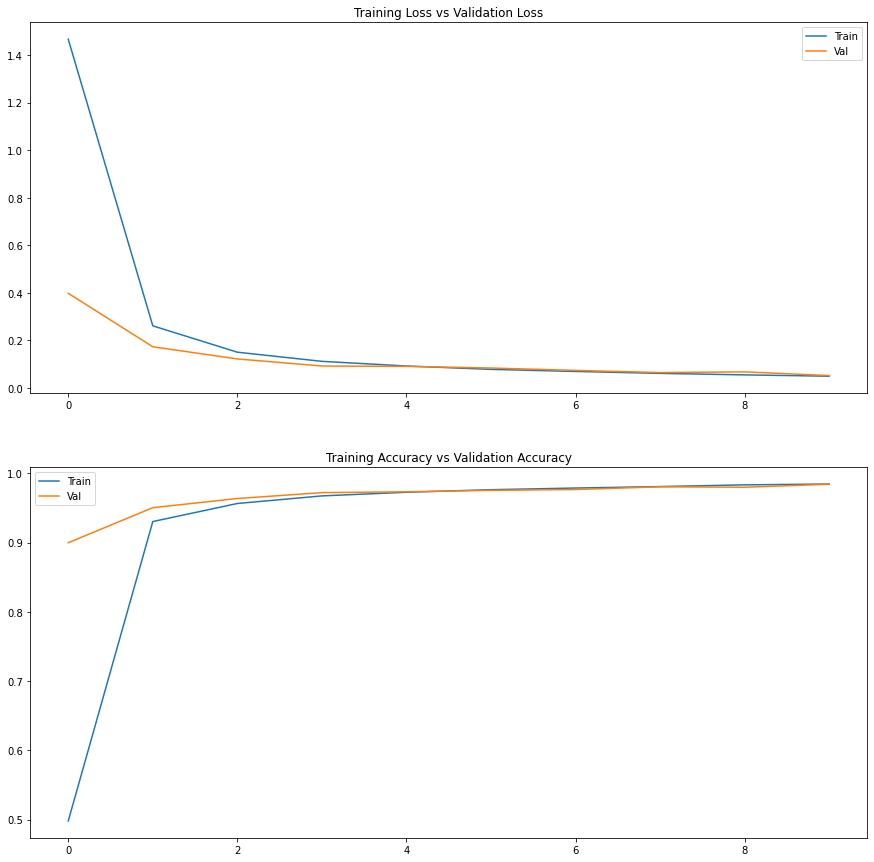

In [59]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

### Changing Architecture to a simpler one (removing multiple layers)

In [65]:
def new_arch_model(model_loss = 'sparse_categorical_crossentropy', model_optimizer = 'adam'):
  model = models.Sequential()
  
  model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='sigmoid', input_shape=(32,32,1)))
  model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='sigmoid'))
  model.add(layers.MaxPooling2D())

  model.add(layers.Flatten())

  model.add(layers.Dense(units=120, activation='sigmoid'))

  # model.add(layers.Dense(units=84, activation='sigmoid'))

  # model.add(layers.Dense(units=40, activation='sigmoid'))

  model.add(layers.Dense(units=10, activation = 'softmax'))

  #compile model
  model.compile(optimizer= model_optimizer, loss = model_loss, metrics=['accuracy'])

  return model

In [66]:
model = new_arch_model(model_loss='sparse_categorical_crossentropy', model_optimizer='adam')
history = model.fit(data_train_CNN, label_train, batch_size=64, epochs=10, validation_data=(data_test_CNN, label_test))

Epoch 1/10
938/938 [==============================] - 10s 10ms/step - loss: 1.1085 - accuracy: 0.6512 - val_loss: 0.3119 - val_accuracy: 0.9102
Epoch 2/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2447 - accuracy: 0.9278 - val_loss: 0.1786 - val_accuracy: 0.9463
Epoch 3/10
938/938 [==============================] - 5s 6ms/step - loss: 0.1597 - accuracy: 0.9524 - val_loss: 0.1254 - val_accuracy: 0.9612
Epoch 4/10
938/938 [==============================] - 5s 6ms/step - loss: 0.1191 - accuracy: 0.9640 - val_loss: 0.0973 - val_accuracy: 0.9684
Epoch 5/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0954 - accuracy: 0.9707 - val_loss: 0.0809 - val_accuracy: 0.9740
Epoch 6/10
938/938 [==============================] - 9s 9ms/step - loss: 0.0806 - accuracy: 0.9758 - val_loss: 0.0716 - val_accuracy: 0.9761
Epoch 7/10
938/938 [==============================] - 8s 9ms/step - loss: 0.0702 - accuracy: 0.9789 - val_loss: 0.0624 - val_accuracy: 0.9797
Epoc

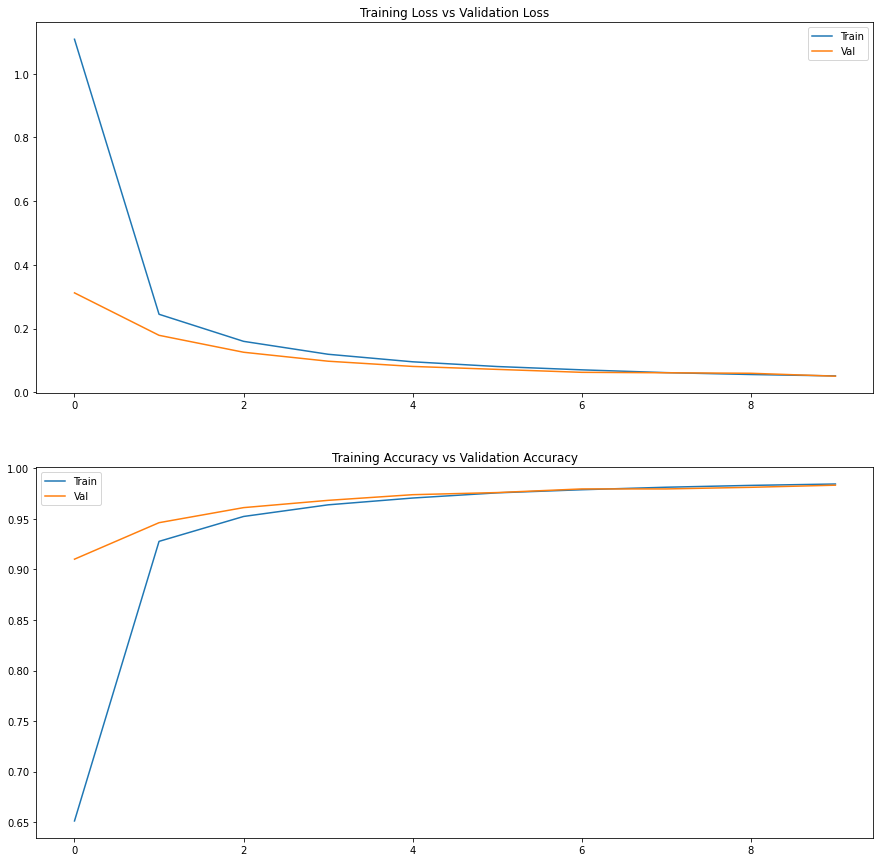

In [67]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

### Changing Architecture by removing even more layers

In [68]:
def new_arch_model(model_loss = 'sparse_categorical_crossentropy', model_optimizer = 'adam'):
  model = models.Sequential()
  
  model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='sigmoid', input_shape=(32,32,1)))
  model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='sigmoid'))
  model.add(layers.MaxPooling2D())

  model.add(layers.Flatten())

  model.add(layers.Dense(units=10, activation = 'softmax'))

  #compile model
  model.compile(optimizer= model_optimizer, loss = model_loss, metrics=['accuracy'])

  return model

In [69]:
model = new_arch_model(model_loss='sparse_categorical_crossentropy', model_optimizer='adam')
history = model.fit(data_train_CNN, label_train, batch_size=64, epochs=10, validation_data=(data_test_CNN, label_test))

Epoch 1/10
938/938 [==============================] - 6s 6ms/step - loss: 1.4020 - accuracy: 0.5378 - val_loss: 0.4756 - val_accuracy: 0.8647
Epoch 2/10
938/938 [==============================] - 8s 8ms/step - loss: 0.4071 - accuracy: 0.8794 - val_loss: 0.3222 - val_accuracy: 0.9072
Epoch 3/10
938/938 [==============================] - 8s 9ms/step - loss: 0.2933 - accuracy: 0.9146 - val_loss: 0.2393 - val_accuracy: 0.9314
Epoch 4/10
938/938 [==============================] - 6s 7ms/step - loss: 0.2222 - accuracy: 0.9362 - val_loss: 0.1893 - val_accuracy: 0.9436
Epoch 5/10
938/938 [==============================] - 5s 5ms/step - loss: 0.1761 - accuracy: 0.9493 - val_loss: 0.1527 - val_accuracy: 0.9565
Epoch 6/10
938/938 [==============================] - 5s 5ms/step - loss: 0.1446 - accuracy: 0.9581 - val_loss: 0.1243 - val_accuracy: 0.9646
Epoch 7/10
938/938 [==============================] - 5s 5ms/step - loss: 0.1229 - accuracy: 0.9645 - val_loss: 0.1070 - val_accuracy: 0.9682
Epoch 

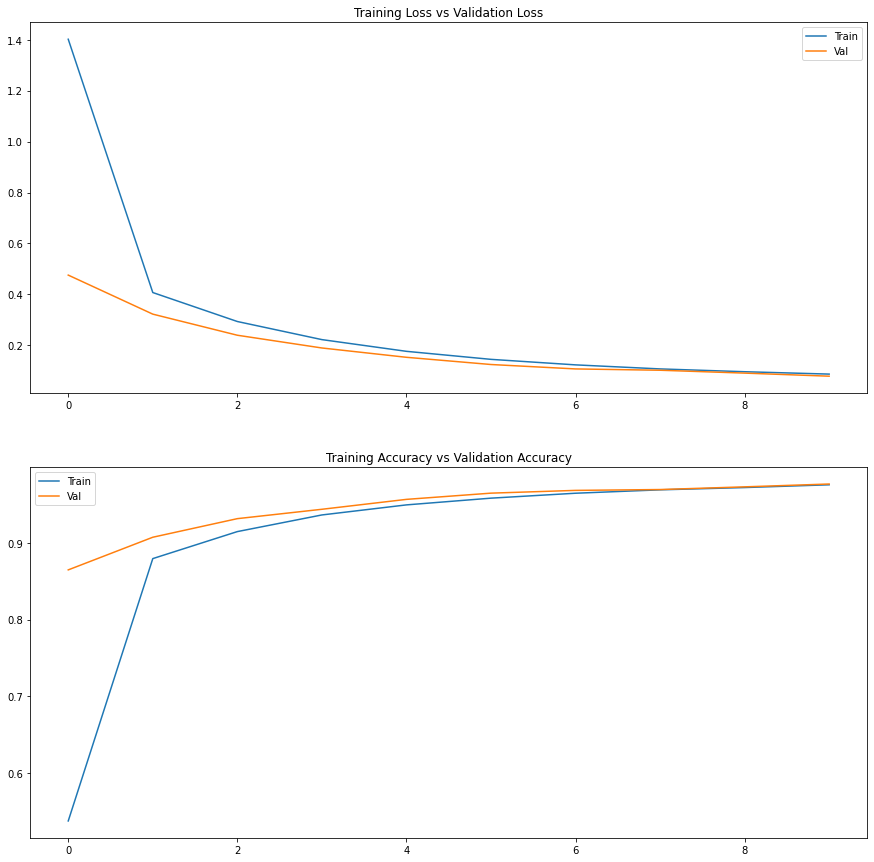

In [70]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

It seems that not only does changing the activation function from relu to sigmoid not have a huge effect, but even removing multiple layers of the CNN still allowed the model to be extremely accurate!


# Takeaways

The takeaways I have gathered are that there are specific loss functions and optimizers that work best for classification, and MNIST in particular, and those are sparse_categorical_crossentropy and Adam Optimizer.

I have also gathered that changing the structure of the model didn't negatively affect its accuracy much, and so making simpler models might be time efficient and more useful.
